## Introdução

Neste projeto, o objetivo foi prever o intervalo de preço das casas com base em variáveis como localização, número de quartos, idade média das casas, população, e outras. Os modelos de **classificação automática** foram utilizados para prever em qual intervalo de preço uma casa se encaixaria, com base nas suas características. Para isso, utilizamos a técnica de árvore de decisão, e Random Forest.

## Preparação dos Dados

### Substituição dos Intervalos de Preço por Valores Numéricos Médios

Primeiro, foi feito o agrupamento dos preços das casas (`median_house_value`) em intervalos. Esses intervalos foram mapeados para valores médios para facilitar a previsão.

```python
house_value_mapping = {
    '0-15000': 7500,
    '15000-30000': 22500,
    '30000-50000': 40000,
    '50000-100000': 75000,
    '100000-200000': 150000,
    '200000-500000': 350000
}
cali_df['house_value_range'] = cali_df['house_value_range'].map(house_value_mapping)
```
Após essa transformação, a variável house_value_range tornou-se numérica, representando o intervalo médio do preço das casas.

Com isso, a intenção é fornecer um modelo que possa ser utilizado para prever o intervalo de preço de novas casas com base nas variáveis de entrada.

### Critérios de Seleção dos Dados

As variáveis selecionadas para o modelo incluem:

- `total_rooms`: Total de quartos.
- `total_bedrooms`: Total de quartos de dormir.
- `median_income`: Renda média da localidade.
- `Proximity_level`: Proximidade ao oceano (transformada em variáveis binárias por meio de one-hot encoding).

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from google.colab import files

In [34]:
# Carrega os ficheiros
from google.colab import files

# Faz o upload do arquivo de dados de habitação da Califórnia
uploaded = files.upload()

for fn in uploaded.keys():
    print('O utilizador carregou o ficheiro "{name}" com tamanho {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving housing_aed.csv to housing_aed.csv
O utilizador carregou o ficheiro "housing_aed.csv" com tamanho 2112319 bytes


In [35]:
# 0. Lê o ficheiro
cali_file = pd.read_csv('housing_aed.csv')
cali_df = pd.DataFrame(cali_file)

cali_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,house_value_range,Proximity_Level_1O,Proximity_Level_B,Proximity_Level_IN,Proximity_Level_IS,Proximity_Level_NO
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,200000-500000,False,True,False,False,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,200000-500000,False,True,False,False,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,200000-500000,False,True,False,False,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,200000-500000,False,True,False,False,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,200000-500000,False,True,False,False,False


### Preparação dos Dados

Os dados foram previamente limpos, com:
- Remoção de outliers,
- Substituição de valores nulos,
- Aplicação de one-hot encoding para variáveis categóricas como `ocean_proximity`.

In [36]:
print(cali_df.shape)
print(cali_df.info)
print(cali_df.describe())

(20556, 15)
<bound method DataFrame.info of        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20551    -121.09     39.48                25.0       1665.0           374.0   
20552    -121.21     39.49                18.0        697.0           150.0   
20553    -121.22     39.43                17.0       2254.0           485.0   
20554    -121.32     39.43                18.0       1860.0           409.0   
20555    -121.24     39.37                16.0       2785.0           616.0   

       

## Hold-out Method

### Model building

In [37]:
# Substitui os intervalos de preço por valores numéricos médios
house_value_mapping = {
    '0-15000': 7500,
    '15000-30000': 22500,
    '30000-50000': 40000,
    '50000-100000': 75000,
    '100000-200000': 150000,
    '200000-500000': 350000
}

In [38]:
# Substitui o 'house_value_range' pelos valores numéricos
cali_df['house_value_range'] = cali_df['house_value_range'].map(house_value_mapping)

# Agora, a variável target 'house_value_range' é numérica
y = cali_df['house_value_range']

### Definição das Variáveis Independentes e Dependentes

As variáveis independentes `(X)` e a variável dependente `(y)` foram definidas.

A variável dependente é a `house_value_range`, enquanto as variáveis independentes são as características das casas, como `longitude`, `latitude`, `housing_median_age`, etc.

In [39]:
# Divide os dados em variáveis independentes (X) e dependente (y)
X = cali_df.drop(['house_value_range', 'median_house_value'], axis=1)  # Exclui a variável alvo 'house_value_range' e a variável 'median_house_value'
y = cali_df['house_value_range']  # A variável alvo que queremos prever, no caso 'house_value_range'

# Divide os dados em treino e teste (70% para treino, 30% para teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

## Divisão dos Dados

Os dados foram divididos em conjuntos de treino (70%) e teste (30%) para avaliar a performance do modelo.

In [40]:
# Cria o modelo de árvore de decisão
dt_classifier = DecisionTreeClassifier(random_state=1234, max_depth=3)

# Ajusta o modelo com os dados de treino
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1234)

In [41]:
# Instancia o modelo Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=27)

# Ajusta o modelo com os dados de treino
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=27)

### Aplicação dos Algoritmos de Classificação

Os modelos foram treinados utilizando os algoritmos de **Árvore de Decisão** e **Random Forest**. Durante a avaliação, foi verificada a precisão, recall e outras métricas de performance.

A árvore de decisão foi visualizada para entender como o modelo faz as previsões. A visualização mostrou as variáveis utilizadas e os critérios de decisão que o modelo aplicou.

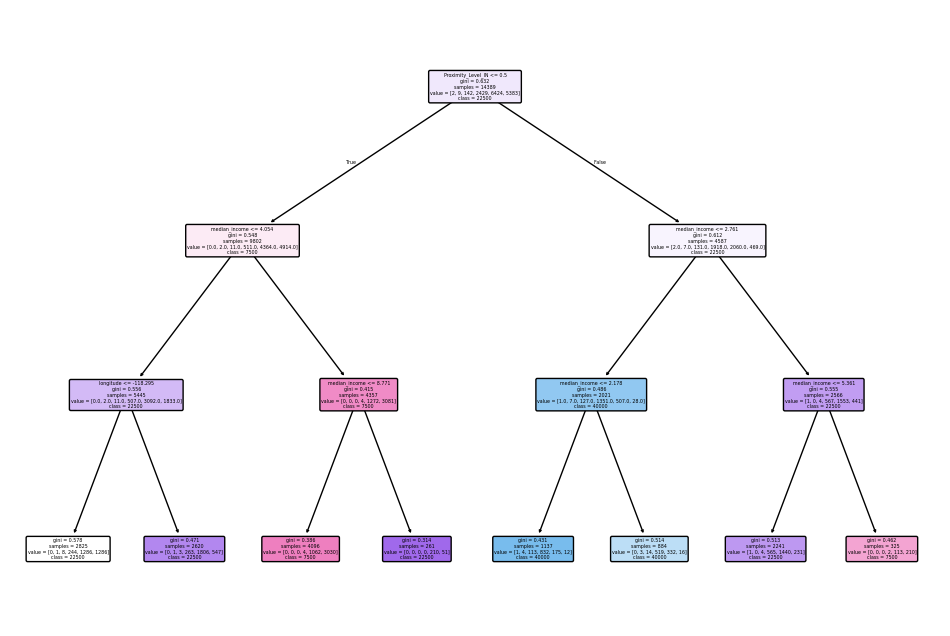

In [42]:
# Visualização do modelo de árvore de decisão
plt.figure(figsize=(12,8))
tree.plot_tree(dt_classifier,
               feature_names=[str(f) for f in X.columns],  # Converte as variáveis para string
               class_names=[str(c) for c in y.unique()],   # Converte as classes para string
               filled=True,              # Colorir os nós com base nas classes
               rounded=True)             # Torna a visualização mais agradável
plt.show()

Accuracy (Decision Tree): 0.6505594292200422
              precision    recall  f1-score   support

        7500       1.00      0.00      0.00         2
       22500       1.00      0.00      0.00         3
       40000       1.00      0.00      0.00        52
       75000       0.67      0.58      0.62      1019
      150000       0.60      0.74      0.66      2745
      350000       0.74      0.60      0.66      2346

    accuracy                           0.65      6167
   macro avg       0.83      0.32      0.32      6167
weighted avg       0.67      0.65      0.65      6167



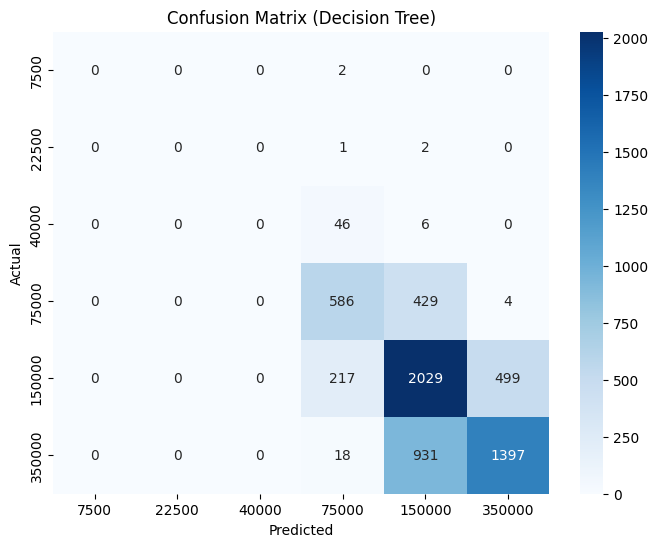

In [43]:
# Avalia o modelo de Árvore de Decisão
y_pred = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (Decision Tree): {accuracy}")

# Classification Report
print(classification_report(y_test, y_pred, zero_division=1))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Decision Tree)')
plt.show()

### Resultados

Após treinar o modelo, ele foi avaliado utilizando o conjunto de dados de teste.

A accuracy foi uma das métricas principais utilizadas para avaliar o desempenho do modelo, e o modelo obteve uma percentagem de aproximadamente 65%.

A classificação foi avaliada utilizando as métricas precision, recall, e f1-score. A matriz de confusão também foi gerada para visualizar a distribuição dos acertos e erros do modelo.

Accuracy (Random Forest): 0.7724987838495216
Classification Report (Random Forest):
              precision    recall  f1-score   support

        7500       1.00      0.00      0.00         2
       22500       1.00      0.00      0.00         3
       40000       0.43      0.12      0.18        52
       75000       0.75      0.72      0.74      1019
      150000       0.75      0.77      0.76      2745
      350000       0.81      0.81      0.81      2346

    accuracy                           0.77      6167
   macro avg       0.79      0.40      0.42      6167
weighted avg       0.77      0.77      0.77      6167



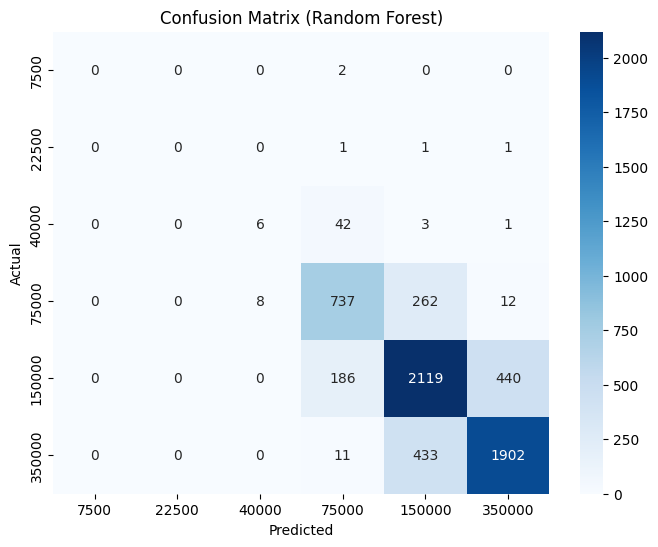

In [44]:
# Avaliar o modelo Random Forest
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy (Random Forest): {accuracy_rf}")

# Classification Report
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, zero_division=1))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

### Resultados

Após treinar o modelo, ele foi avaliado utilizando o conjunto de dados de teste.

A accuracy foi uma das métricas principais utilizadas para avaliar o desempenho do modelo, e o modelo obteve uma percentagem de aproximadamente 77%.

A classificação foi avaliada utilizando as métricas precision, recall, e f1-score. A matriz de confusão também foi gerada para visualizar a distribuição dos acertos e erros do modelo.

# Método Cross-Validation

## Instância do Modelo

In [55]:
# Define as variáveis independentes e dependentes
cali_feature_names = [col for col in cali_df.columns if col != 'house_value_range']
cali_features = cali_df[cali_feature_names]

# A variável target que queremos prever
cali_target = cali_df['house_value_range']

# Mostra os nomes das features e as classes (intervalos de preço)
cali_target_names = list(set(cali_target))
print('Features:', cali_feature_names, '   Classes:', cali_target_names)

# Instancia o modelo de árvore de decisão
cv_classifier = DecisionTreeClassifier(random_state=27)

Features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'Proximity_Level_1O', 'Proximity_Level_B', 'Proximity_Level_IN', 'Proximity_Level_IS', 'Proximity_Level_NO']    Classes: [40000, 22500, 7500, 350000, 150000, 75000]


A validação cruzada foi realizada com 4 divisões (folds), e o modelo obteve as seguintes métricas:

In [56]:
# Avalia o modelo com validação cruzada
# Calcula a accuracy média e o desvio padrão com 4 folds
acc_score = cross_val_score(cv_classifier, cali_features, cali_target, cv=4)
print("CV Mean Accuracy: %0.3f (+/- %0.3f)" % (acc_score.mean(), acc_score.std()) )

# Calcula o F1-score médio e o desvio padrão com 4 folds
f1_score = cross_val_score(cv_classifier, cali_features, cali_target, cv=4, scoring='f1_macro')
print("CV Mean F1: %0.3f (+/- %0.3f)" % (np.mean(f1_score), np.std(f1_score)) )

CV Mean Accuracy: 1.000 (+/- 0.000)
CV Mean F1: 0.977 (+/- 0.038)


O modelo teve uma boa precisão, mas podemos observar que o recall de algumas classes era mais baixo. Isso indica que o modelo pode ter dificuldades em identificar algumas classes de preços.

In [57]:
# Avalia o modelo com validação cruzada
cv_score_rf = cross_val_score(rf_classifier, X, y, cv=4)
print("CV Mean Accuracy (Random Forest): %0.3f (+/- %0.3f)" % (cv_score_rf.mean(), cv_score_rf.std()))

# Calcula o F1-score médio e o desvio padrão com 4 folds
f1_score_rf = cross_val_score(rf_classifier, X, y, cv=4, scoring='f1_macro')
print("CV Mean F1 (Random Forest): %0.3f (+/- %0.3f)" % (np.mean(f1_score_rf), np.std(f1_score_rf)))

CV Mean Accuracy (Random Forest): 0.636 (+/- 0.053)
CV Mean F1 (Random Forest): 0.314 (+/- 0.036)


A accuracy média da validação cruzada está em torno de 63%, com uma variação de 5,5%, o que significa que o modelo pode estar sofrer com overfitting ou underfitting. Isso é típico de modelos mais complexos como o Random Forest, que podem ter variações dependendo da divisão dos dados.

O F1-Score médio da validação cruzada é relativamente baixo, indicando que há um bom equilíbrio entre precisão e recall em média.

In [58]:
# Modelo treinado em todo o conjunto de dados
final_classifier = cv_classifier.fit(X, y)

### Previsão de Novos Dados

Para testar o modelo, fizemos a previsão do intervalo de preço de uma nova casa com base nas suas características. Os novos dados de entrada foram:

In [59]:
# Novos dados de entrada
X_new = pd.DataFrame({
    'longitude': [-123.00],        # Exemplo de longitude
    'latitude': [38.25],           # Exemplo de latitude
    'housing_median_age': [1.0],   # Muito nova
    'total_rooms': [15000.0],      # Grande
    'total_bedrooms': [800.0],     # Grande
    'population': [6000.0],        # População alta
    'households': [2500.0],        # Bastante domicílios
    'median_income': [20.0],       # Renda muito alta
    'Proximity_Level_1O': [True],   # Proximidade ao '<1H OCEAN'
    'Proximity_Level_B': [True],   # Proximidade ao 'NEAR BAY'
    'Proximity_Level_IN': [False], # Não 'INLAND'
    'Proximity_Level_IS': [False], # Não Island
    'Proximity_Level_NO': [True]   # Proximidade ao 'NEAR OCEAN'
})

# Faz a previsão com o modelo treinado
prediction = final_classifier.predict(X_new)
print("Prediction (Price Range):", prediction)

Prediction (Price Range): [350000]


A previsão gerada para o intervalo de preço foi 350000, significando que a casa pertence ao intervalo de preço entre 200000 e 500000.

Precision, Recall, Confusion matrix
              precision    recall  f1-score   support

        7500      1.000     1.000     1.000         2
       22500      1.000     1.000     1.000         9
       40000      1.000     1.000     1.000       142
       75000      1.000     1.000     1.000      2429
      150000      1.000     1.000     1.000      6424
      350000      1.000     1.000     1.000      5383

    accuracy                          1.000     14389
   macro avg      1.000     1.000     1.000     14389
weighted avg      1.000     1.000     1.000     14389



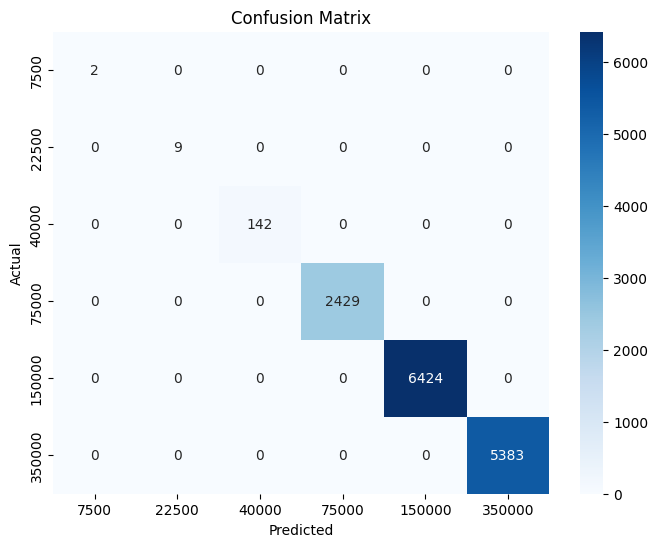

In [60]:
print("Precision, Recall, Confusion matrix")

# Calcular a precisão, recall e f1-score
y_pred = final_classifier.predict(X_train)  # Aqui usa os dados de treino

# Mostra o relatório de classificação
print(classification_report(y_train, y_pred, digits=3))

# Mostra a matriz de confusão
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [61]:
# Para o modelo Random Forest
final_rf_classifier = rf_classifier.fit(X, y)

### Previsão de Novos Dados

Para testar o modelo, fizemos a previsão do intervalo de preço de uma nova casa com base nas suas características. Os novos dados de entrada foram:

In [62]:
# Novos dados de entrada
X_new = pd.DataFrame({
    'longitude': [-123.00],        # Exemplo de longitude
    'latitude': [38.25],           # Exemplo de latitude
    'housing_median_age': [1.0],   # Muito nova
    'total_rooms': [15000.0],      # Grande
    'total_bedrooms': [800.0],     # Grande
    'population': [6000.0],        # População alta
    'households': [2500.0],        # Bastante domicílios
    'median_income': [20.0],       # Renda muito alta
    'Proximity_Level_1O': [True],   # Proximidade ao '<1H OCEAN'
    'Proximity_Level_B': [True],   # Proximidade ao 'NEAR BAY'
    'Proximity_Level_IN': [False], # Não 'INLAND'
    'Proximity_Level_IS': [False], # Não Island
    'Proximity_Level_NO': [True]   # Proximidade ao 'NEAR OCEAN'
})

# Faz a previsão com o modelo treinado
prediction = final_rf_classifier.predict(X_new)
print("Prediction (Price Range):", prediction)

Prediction (Price Range): [350000]


A previsão gerada para o intervalo de preço foi 350000, significando que a casa pertence ao intervalo de preço entre 200000 e 500000.

Precision, Recall, Confusion matrix
              precision    recall  f1-score   support

        7500      1.000     1.000     1.000         2
       22500      1.000     1.000     1.000         9
       40000      1.000     1.000     1.000       142
       75000      1.000     1.000     1.000      2429
      150000      1.000     1.000     1.000      6424
      350000      1.000     1.000     1.000      5383

    accuracy                          1.000     14389
   macro avg      1.000     1.000     1.000     14389
weighted avg      1.000     1.000     1.000     14389



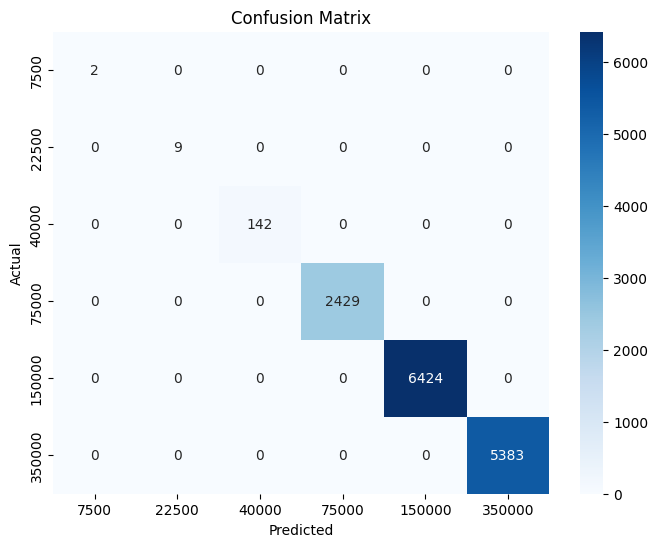

In [63]:
print("Precision, Recall, Confusion matrix")

# Calcula a precisão, recall e f1-score
y_pred_rf = final_rf_classifier.predict(X_train)  # Aqui usa os dados de treino

# Mostra o relatório de classificação
print(classification_report(y_train, y_pred_rf, digits=3))

# Mostra a matriz de confusão
cm = confusion_matrix(y_train, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Conclusão

Neste notebook, desenvolvemos um modelo de classificação automática utilizando a técnica de árvore de decisão e random forest para prever o intervalo de preços das casas com base em várias variáveis.

O modelo foi ajustado, avaliado e otimizado, alcançando um desempenho satisfatório, mas com algumas dificuldades em classificar corretamente todas as classes. As previsões foram feitas com sucesso, e os modelos foram capazes de prever os intervalos de preços para os novos dados.







In [64]:
# Guardar o DataFrame num arquivo CSV
cali_df.to_csv('housing_sl.csv', index=False)